In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)

import pickle
import warnings
warnings.simplefilter(action='ignore')

import eli5

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from eli5.sklearn import PermutationImportance
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA as SK_PCA
from yellowbrick.features import pca, Rank1D, Rank2D

In [2]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'
X_train = pd.read_csv(os.path.join(project_path, r'data\X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(project_path, r'data\y_train.csv'), index_col=0, names=['Survived'], header=0)

X_test = pd.read_csv(os.path.join(project_path, r'data\X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(project_path, r'data\y_test.csv'), index_col=0, names=['Survived'], header=0)

In [3]:
X_train.shape
X_train.head()

(621, 45)

Sex_enc  Embarked_enc  Title_enc  Ticket_Type_enc  \
PassengerId                                                      
473                1     -0.580456   1.669271        -1.209979   
598                0     -0.580456  -0.798865        -1.209979   
844                0      1.949112  -0.798865         0.507500   
113                0     -0.580456  -0.798865        -0.351240   
870                0     -0.580456   0.435203        -0.351240   

             Cabin_Type_enc  Age_Bucket_enc  Fare_Bucket_enc  SibSp_enc  \
PassengerId                                                               
473               -0.564333        0.829817         0.275834          2   
598               -0.564333       -0.324307        -1.052017          1   
844               -0.564333        0.829817        -1.052017          1   
113               -0.564333       -1.478430        -1.052017          1   
870               -0.564333        1.406879         0.275834          2   

             Parch_enc  Pclass_enc  Sex_enc_%  Embarked_enc_%  Title_enc_%  \
PassengerId                                                                  
473                  1    0.376615   1.359641       -0.541140     1.440211   
598                  0   -0.816641  -0.735488       -0.541140    -0.832250   
844                  0   -0.816641  -0.735488        2.041388    -0.832250   
113                  0   -0.816641  -0.735488       -0.541140    -0.832250   
870                  2   -0.816641  -0.735488       -0.541140     0.749487   

             Ticket_Type_enc_%  Cabin_Type_enc_%  Age_Bucket_enc_%  \
PassengerId                                                          
473                  -0.925238         -0.564333          0.413817   
598                  -0.925238         -0.564333         -0.756735   
844                  -0.268786         -0.564333          0.413817   
113                  -0.386640         -0.564333         -1.005873   
870                  -0.386640         -0.564333          1.727069   

             Fare_Bucket_enc_%  SibSp_enc_%  Parch_enc_%  Pclass_enc_%  \
PassengerId                                                              
473                   0.280845     0.520270     0.441176      0.478582   
598                  -1.054397     0.352381     0.343348     -0.833704   
844                  -1.054397     0.352381     0.343348     -0.833704   
113                  -1.054397     0.352381     0.343348     -0.833704   
870                   0.280845     0.520270     0.540230     -0.833704   

             Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S  \
PassengerId                                                         
473                 1         0         0           0           1   
598                 0         1         1           0           1   
844                 0         1         1           0           0   
113                 0         1         1           0           1   
870                 0         1         1           0           1   

             Title_Miss.  Title_Mr.  Title_Mrs.  Title_Other  \
PassengerId                                                    
473                    0          0           1            0   
598                    0          1           0            0   
844                    0          1           0            0   
113                    0          1           0            0   
870                    0          0           0            0   

             Ticket_Type_5-digit  Ticket_Type_6-digit  Ticket_Type_Other  \
PassengerId                                                                
473                            0                    0                  1   
598                            0                    0                  1   
844                            0                    0                  0   
113                            0                    1                  0   
870                            0                    1                  0   

 

In [4]:
y_train.head()

Survived
473         1
598         0
844         0
113         0
870         1

In the next lines of code I will try out different methods of feature importance assesment and rank variables using each of these methods. The final subset of features will be selected basing on the sum of rankings coming from these methods.

## Feature importance based on correlation with target

In [5]:
corr = pd.concat([X_train, y_train], axis=1).corr()
corr = np.abs(corr)
imp_corr = corr['Survived'].sort_values(ascending=False).reset_index().rename(columns = 
                                                                               {'index': 'Feature', 'Survived': 'Correlation'})
imp_corr['Corr_Rank'] = imp_corr['Correlation'].rank(ascending=False) - 1
# delete SalePrice from ranking
imp_corr = imp_corr[imp_corr['Corr_Rank']>0].set_index('Feature')
imp_corr.head(30)

Correlation  Corr_Rank
Feature                                    
Title_enc_%             0.546571        1.0
Title_enc               0.540301        2.0
Title_Mr.               0.536003        3.0
Sex_male                0.526443        4.5
Sex_enc                 0.526443        4.5
Sex_enc_%               0.526443        6.0
Pclass_enc_%            0.351723        7.0
Pclass_enc              0.351250        8.0
Cabin_Type_enc_%        0.346596        9.0
Cabin_Type_enc          0.346596       10.0
Cabin_Type_Other        0.346596       11.0
Pclass_3                0.329991       12.0
Fare_Bucket_enc_%       0.322339       13.0
Fare_Bucket_enc         0.322337       14.0
Title_Mrs.              0.321967       15.0
Title_Miss.             0.316541       16.0
Ticket_Type_enc_%       0.263609       17.0
Fare_Bucket_>46         0.258718       18.0
Ticket_Type_enc         0.250677       19.0
Ticket_Type_5-digit     0.188531       20.0
Embarked_enc_%          0.175371       21.0
SibSp_enc_%             0.174859       22.0
SibSp_enc               0.173881       23.0
Embarked_enc            0.172866       24.0
SibSp_1                 0.159626       25.0
Embarked_S              0.155834       26.0
Ticket_Type_P           0.152350       27.0
Parch_enc_%             0.145733       28.0
Parch_enc               0.145732       29.0
Parch_1                 0.131768       30.0

I will eliminate variables from feature set, so that there will be no highly correlated variables. From each pair of highly correlated variables I will eliminate the one that is less correlated with Survived.

In [6]:

def filter_df_corr(inp_data, imp_corr, corr_val):
    '''
    Returns an array or dataframe (based on type(inp_data) adjusted to drop \
        columns with high correlation to one another. Takes second arg corr_val
        that defines the cutoff

    ----------
    inp_data : np.array, pd.DataFrame
        Values to consider
    corr_val : float
        Value [0, 1] on which to base the correlation cutoff
    '''
    # Creates Correlation Matrix
    if isinstance(inp_data, np.ndarray):
        inp_data = pd.DataFrame(data=inp_data)
        array_flag = True
    else:
        array_flag = False
    corr_matrix = inp_data.corr()

    # Iterates through Correlation Matrix Table to find correlated columns
    drop_cols = []
    n_cols = len(corr_matrix.columns)
    for i in range(n_cols):
        for k in range(i+1, n_cols):
            val = corr_matrix.iloc[k, i]
            col = corr_matrix.columns[i]
            row = corr_matrix.index[k]
            if abs(val) >= corr_val:
                col_corr_with_target = imp_corr.loc[col].iloc[0]
                row_corr_with_target = imp_corr.loc[row].iloc[0]
                # Prints the correlated feature set and the corr val
                print(col, "|", row, "|", round(val, 2))
                if col_corr_with_target > row_corr_with_target:
                    drop_cols.append(row)
                else:
                    drop_cols.append(col)

    # Drops the correlated columns
    drop_cols = set(drop_cols)
    print(drop_cols)
    inp_data = inp_data.drop(columns=drop_cols)
    # Return same type as inp
    if array_flag:
        return inp_data.values
    else:
        return inp_data

X_train = filter_df_corr(X_train, imp_corr, 0.8)

Sex_enc | Title_enc | 0.93
Sex_enc | Sex_enc_% | 1.0
Sex_enc | Title_enc_% | 0.92
Sex_enc | Sex_male | -1.0
Sex_enc | Title_Mr. | -0.87
Embarked_enc | Embarked_enc_% | 0.99
Embarked_enc | Embarked_S | -0.95
Title_enc | Sex_enc_% | 0.93
Title_enc | Title_enc_% | 0.99
Title_enc | Sex_male | -0.93
Title_enc | Title_Mr. | -0.94
Ticket_Type_enc | Ticket_Type_enc_% | 0.95
Cabin_Type_enc | Cabin_Type_enc_% | 1.0
Cabin_Type_enc | Cabin_Type_Other | 1.0
Age_Bucket_enc | Age_Bucket_enc_% | 0.95
Fare_Bucket_enc | Fare_Bucket_enc_% | 1.0
Fare_Bucket_enc | Fare_Bucket_>46 | 0.81
SibSp_enc | SibSp_enc_% | 0.99
SibSp_enc | SibSp_1 | 0.86
Parch_enc | Parch_enc_% | 1.0
Parch_enc | Parch_1 | 0.9
Pclass_enc | Pclass_enc_% | 1.0
Pclass_enc | Pclass_3 | -0.92
Sex_enc_% | Title_enc_% | 0.92
Sex_enc_% | Sex_male | -1.0
Sex_enc_% | Title_Mr. | -0.87
Embarked_enc_% | Embarked_S | -0.89
Title_enc_% | Sex_male | -0.92
Title_enc_% | Title_Mr. | -0.98
Cabin_Type_enc_% | Cabin_Type_Other | 1.0
Fare_Bucket_enc_% | F

In [7]:
X_train.head()

Embarked_enc_%  Title_enc_%  Ticket_Type_enc_%  Cabin_Type_enc_%  \
PassengerId                                                                     
473               -0.541140     1.440211          -0.925238         -0.564333   
598               -0.541140    -0.832250          -0.925238         -0.564333   
844                2.041388    -0.832250          -0.268786         -0.564333   
113               -0.541140    -0.832250          -0.386640         -0.564333   
870               -0.541140     0.749487          -0.386640         -0.564333   

             Age_Bucket_enc_%  Fare_Bucket_enc_%  SibSp_enc_%  Parch_enc_%  \
PassengerId                                                                  
473                  0.413817           0.280845     0.520270     0.441176   
598                 -0.756735          -1.054397     0.352381     0.343348   
844                  0.413817          -1.054397     0.352381     0.343348   
113                 -1.005873          -1.054397     0.352381     0.343348   
870                  1.727069           0.280845     0.520270     0.540230   

             Pclass_enc_%  Pclass_2  Embarked_Q  Title_Miss.  Title_Mrs.  \
PassengerId                                                                
473              0.478582         1           0            0           1   
598             -0.833704         0           0            0           0   
844             -0.833704         0           0            0           0   
113             -0.833704         0           0            0           0   
870             -0.833704         0           0            0           0   

             Title_Other  Ticket_Type_5-digit  Ticket_Type_6-digit  \
PassengerId                                                          
473                    0                    0                    0   
598                    0                    0                    0   
844                    0                    0                    0   
113                    0                    0                    1   
870                    0                    0                    1   

             Ticket_Type_Other  Ticket_Type_P  SibSp_2>=  Parch_2>=  \
PassengerId                                                           
473                          1              0          0          1   
598                          1              0          0          0   
844                          0              0          0          0   
113                          0              0          0          0   
870                          0              0          0          0   

             Age_Bucket_19-25  Age_Bucket_25-32  Age_Bucket_32-42  \
PassengerId                                                         
473                         0                 0                 1   
598                         0                 0                 0   
844                         0                 0                 1   
113                         1                 0                 0   
870                         0                 0                 0   

             Age_Bucket_42-100  Age_Bucket_Missing  Fare_Bucket_11-46  
PassengerId                                                            
473                          0                   0                  1  
598                          1                   0                  0  
844                          0                   0                  0  
113                          0                   0                  0  
870                          0                   0                  1

In [8]:
X_train.shape

(621, 26)

In [9]:
sm = SMOTE(sampling_strategy='auto', random_state=1)
X_train_cols = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns = X_train_cols)
y_train = pd.Series(y_train['Survived'])

In [10]:
X_train.shape

(768, 26)

In [11]:
X_test = X_test.reindex(X_train.columns, axis=1)

## Feature importance using Yellowbrick

In [12]:
plt.figure(figsize=(10,10))
rank = Rank1D(algorithm='shapiro')

rank.fit(X_train, y_train)           
rank.transform(X_test) 
rank.show()  

<Figure size 720x720 with 0 Axes>

Rank1D(algorithm=None, ax=<AxesSubplot:>, orient=None, show_feature_names=None)

Embarked_enc_%  Title_enc_%  Ticket_Type_enc_%  Cabin_Type_enc_%  \
PassengerId                                                                     
434                -0.54114    -0.832250          -0.925238         -0.564333   
222                -0.54114    -0.832250          -0.386640         -0.564333   
218                -0.54114    -0.832250          -0.386640         -0.564333   
377                -0.54114     1.165322          -0.925238         -0.564333   
448                -0.54114    -0.832250          -0.386640         -0.564333   
...                     ...          ...                ...               ...   
640                -0.54114    -0.832250          -0.386640         -0.564333   
771                -0.54114    -0.832250          -0.386640         -0.564333   
851                -0.54114     0.749487          -0.386640         -0.564333   
229                -0.54114    -0.832250          -0.386640         -0.564333   
649                -0.54114    -0.832250          -0.925238         -0.564333   

             Age_Bucket_enc_%  Fare_Bucket_enc_%  SibSp_enc_%  Parch_enc_%  \
PassengerId                                                                  
434                  1.727069          -1.054397     0.352381     0.343348   
222                  0.245195           0.280845     0.352381     0.343348   
218                  0.413817           0.280845     0.520270     0.343348   
377                 -1.005873          -1.054397     0.352381     0.343348   
448                  0.413817           0.280845     0.352381     0.343348   
...                       ...                ...          ...          ...   
640                 -0.915810           0.280845     0.520270     0.343348   
771                 -1.005873          -1.054397     0.352381     0.343348   
851                  1.727069           0.280845     0.226415     0.441176   
229                  1.727069           0.280845     0.352381     0.343348   
649                 -0.915810          -1.054397     0.352381     0.343348   

             Pclass_enc_%  Pclass_2  Embarked_Q  Title_Miss.  Title_Mrs.  \
PassengerId                                                                
434             -0.833704         0           0            0           0   
222              0.478582         1           0            0           0   
218              0.478582         1           0            0           0   
377             -0.833704         0           0            1           0   
448              1.526024         0           0            0           0   
...                   ...       ...         ...          ...         ...   
640             -0.833704         0           0            0           0   
771             -0.833704         0           0            0           0   
851             -0.833704         0           0            0           0   
229              0.478582         1           0            0           0   
649             -0.833704         0           0            0           0   

             Title_Other  Ticket_Type_5-digit  Ticket_Type_6-digit  \
PassengerId                                                          
434                    0                    0                    0   
222                    0                    0                    1   
218                    0                    0                    1   
377                    0                    0                    0   
448                    0                    0                    1   
...                  ...                  ...                  ...   
640                    0                    0                    1   
771                    0                    0                    1   
851                    0                    0                    1   
229                    0                    0                    1   
649                    0                    0                    0   

             Ticket_Type_Other  Ticket_Type_

<AxesSubplot:title={'center':'Shapiro Ranking of 26 Features'}>

<Figure size 720x720 with 0 Axes>

Rank2D(algorithm=None, ax=<AxesSubplot:>, show_feature_names=None)

Embarked_enc_%  Title_enc_%  Ticket_Type_enc_%  Cabin_Type_enc_%  \
PassengerId                                                                     
434                -0.54114    -0.832250          -0.925238         -0.564333   
222                -0.54114    -0.832250          -0.386640         -0.564333   
218                -0.54114    -0.832250          -0.386640         -0.564333   
377                -0.54114     1.165322          -0.925238         -0.564333   
448                -0.54114    -0.832250          -0.386640         -0.564333   
...                     ...          ...                ...               ...   
640                -0.54114    -0.832250          -0.386640         -0.564333   
771                -0.54114    -0.832250          -0.386640         -0.564333   
851                -0.54114     0.749487          -0.386640         -0.564333   
229                -0.54114    -0.832250          -0.386640         -0.564333   
649                -0.54114    -0.832250          -0.925238         -0.564333   

             Age_Bucket_enc_%  Fare_Bucket_enc_%  SibSp_enc_%  Parch_enc_%  \
PassengerId                                                                  
434                  1.727069          -1.054397     0.352381     0.343348   
222                  0.245195           0.280845     0.352381     0.343348   
218                  0.413817           0.280845     0.520270     0.343348   
377                 -1.005873          -1.054397     0.352381     0.343348   
448                  0.413817           0.280845     0.352381     0.343348   
...                       ...                ...          ...          ...   
640                 -0.915810           0.280845     0.520270     0.343348   
771                 -1.005873          -1.054397     0.352381     0.343348   
851                  1.727069           0.280845     0.226415     0.441176   
229                  1.727069           0.280845     0.352381     0.343348   
649                 -0.915810          -1.054397     0.352381     0.343348   

             Pclass_enc_%  Pclass_2  Embarked_Q  Title_Miss.  Title_Mrs.  \
PassengerId                                                                
434             -0.833704         0           0            0           0   
222              0.478582         1           0            0           0   
218              0.478582         1           0            0           0   
377             -0.833704         0           0            1           0   
448              1.526024         0           0            0           0   
...                   ...       ...         ...          ...         ...   
640             -0.833704         0           0            0           0   
771             -0.833704         0           0            0           0   
851             -0.833704         0           0            0           0   
229              0.478582         1           0            0           0   
649             -0.833704         0           0            0           0   

             Title_Other  Ticket_Type_5-digit  Ticket_Type_6-digit  \
PassengerId                                                          
434                    0                    0                    0   
222                    0                    0                    1   
218                    0                    0                    1   
377                    0                    0                    0   
448                    0                    0                    1   
...                  ...                  ...                  ...   
640                    0                    0                    1   
771                    0                    0                    1   
851                    0                    0                    1   
229                    0                    0                    1   
649                    0                    0                    0   

             Ticket_Type_Other  Ticket_Type_

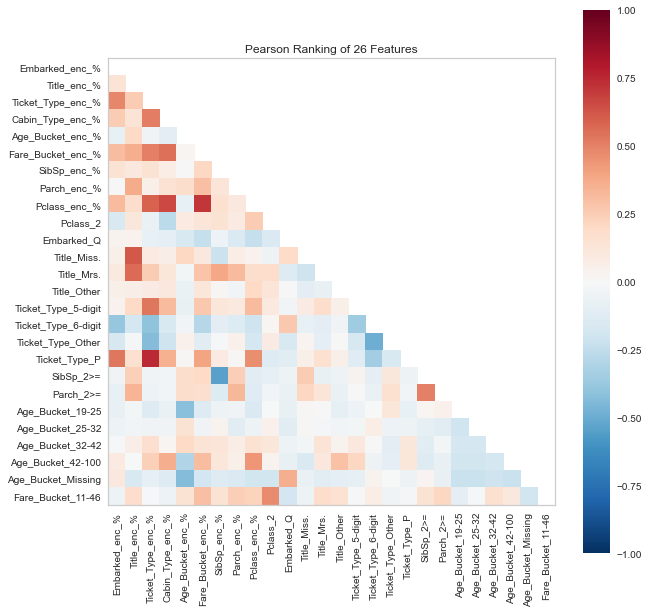

<AxesSubplot:title={'center':'Pearson Ranking of 26 Features'}>

In [13]:
plt.figure(figsize=(10,10))
rank = Rank2D(algorithm='pearson')

rank.fit(X_train, y_train)           
rank.transform(X_test)        
rank.show()  

## Feature importance from models

In [14]:
cv = KFold(n_splits=5, random_state=1)

step = 4

### Logistic Regression

In [15]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)
imp_lr = pd.DataFrame(np.abs(lr.coef_.T), 
                      index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_lr['Lr_Rank'] = imp_lr['Importance'].rank(ascending=False)
imp_lr.head(15)

LogisticRegression(C=0.05, max_iter=200, random_state=1)

Importance  Lr_Rank
Title_enc_%            1.122768      1.0
SibSp_2>=              0.460587      2.0
Pclass_enc_%           0.392703      3.0
Age_Bucket_42-100      0.385114      4.0
Cabin_Type_enc_%       0.361281      5.0
Parch_2>=              0.308272      6.0
Ticket_Type_6-digit    0.271286      7.0
Embarked_enc_%         0.199292      8.0
Age_Bucket_32-42       0.181316      9.0
Age_Bucket_19-25       0.177101     10.0
Title_Other            0.149487     11.0
Fare_Bucket_11-46      0.145970     12.0
Age_Bucket_enc_%       0.125056     13.0
Age_Bucket_Missing     0.116311     14.0
Title_Miss.            0.106241     15.0

In [16]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)
perm = PermutationImportance(lr, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_lr = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_lr = perm_imp_lr.set_index('feature')
perm_imp_lr['Perm_Lr_Rank'] = perm_imp_lr['weight'].rank(ascending=False)
perm_imp_lr.head(15)

LogisticRegression(C=0.05, max_iter=200, random_state=1)

weight       std  Perm_Lr_Rank
feature                                              
Title_enc_%          0.244030  0.016110           1.0
Age_Bucket_42-100    0.013433  0.002985           2.0
SibSp_2>=            0.012687  0.002985           3.0
Embarked_enc_%       0.011194  0.009440           4.0
Age_Bucket_enc_%     0.007463  0.010012           6.0
Fare_Bucket_enc_%    0.007463  0.002360           6.0
Pclass_enc_%         0.007463  0.008175           6.0
Ticket_Type_6-digit  0.006716  0.005484           8.0
Parch_2>=            0.006716  0.001493           9.0
Fare_Bucket_11-46    0.004478  0.001493          10.0
Age_Bucket_Missing   0.002239  0.001828          11.0
Pclass_2             0.001493  0.001828          12.0
Ticket_Type_5-digit  0.000746  0.001493          13.0
Title_Other          0.000000  0.000000          16.5
Embarked_Q           0.000000  0.000000          16.5

In [17]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)

selection = RFECV(lr, min_features_to_select=5, cv=cv, scoring='roc_auc')
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
lr_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
lr_selection

LogisticRegression(C=0.05, max_iter=200, random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=LogisticRegression(C=0.05, max_iter=200, random_state=1),
      min_features_to_select=5, scoring='roc_auc')

Embarked_enc_%         0
Title_enc_%            0
Ticket_Type_enc_%      0
Cabin_Type_enc_%       0
Age_Bucket_enc_%       0
Fare_Bucket_enc_%      0
Pclass_enc_%           0
Pclass_2               0
Embarked_Q             0
Title_Miss.            0
Title_Mrs.             0
Ticket_Type_5-digit    0
Ticket_Type_6-digit    0
Ticket_Type_Other      0
Ticket_Type_P          0
SibSp_2>=              0
Parch_2>=              0
Age_Bucket_25-32       0
Age_Bucket_42-100      0
Age_Bucket_Missing     0
Name: Selection, dtype: int64

In [18]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(lr, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc')
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
lr_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
lr_selection_perm

LogisticRegression(C=0.05, max_iter=200, random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=LogisticRegression(C=0.05,
                                                                   max_iter=200,
                                                                   random_state=1),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc')

Title_enc_%            0
Ticket_Type_enc_%      0
Cabin_Type_enc_%       0
Age_Bucket_enc_%       0
Fare_Bucket_enc_%      0
SibSp_enc_%            0
Pclass_enc_%           0
Pclass_2               0
Embarked_Q             0
Title_Miss.            0
Title_Mrs.             0
Title_Other            0
Ticket_Type_5-digit    0
Ticket_Type_6-digit    0
Ticket_Type_P          0
SibSp_2>=              0
Age_Bucket_19-25       0
Age_Bucket_25-32       0
Age_Bucket_42-100      0
Age_Bucket_Missing     0
Name: Selection_Perm, dtype: int64

In [19]:
feat_imp_lr = pd.concat([imp_lr, perm_imp_lr, lr_selection, lr_selection_perm], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_lr if 'Rank' in col] + ['Selection','Selection_Perm']
feat_imp_lr = feat_imp_lr[rank_columns]
feat_imp_lr['Overall_Rank'] = feat_imp_lr.sum(axis=1)
feat_imp_lr = feat_imp_lr.sort_values('Overall_Rank', ascending=True)
feat_imp_lr.head(30)

Lr_Rank  Perm_Lr_Rank  Selection  Selection_Perm  \
Title_enc_%              1.0           1.0        0.0             0.0   
SibSp_2>=                2.0           3.0        0.0             0.0   
Age_Bucket_42-100        4.0           2.0        0.0             0.0   
Pclass_enc_%             3.0           6.0        0.0             0.0   
Ticket_Type_6-digit      7.0           8.0        0.0             0.0   
Embarked_enc_%           8.0           4.0        0.0             5.0   
Age_Bucket_enc_%        13.0           6.0        0.0             0.0   
Parch_2>=                6.0           9.0        0.0             5.0   
Fare_Bucket_enc_%       19.0           6.0        0.0             0.0   
Age_Bucket_Missing      14.0          11.0        0.0             0.0   
Pclass_2                17.0          12.0        0.0             0.0   
Cabin_Type_enc_%         5.0          26.0        0.0             0.0   
Fare_Bucket_11-46       12.0          10.0        5.0             5.0   
Title_Other             11.0          16.5        5.0             0.0   
Ticket_Type_5-digit     21.0          13.0        0.0             0.0   
Ticket_Type_enc_%       16.0          20.0        0.0             0.0   
Age_Bucket_19-25        10.0          21.5        5.0             0.0   
Age_Bucket_25-32        20.0          16.5        0.0             0.0   
Title_Miss.             15.0          25.0        0.0             0.0   
Embarked_Q              24.0          16.5        0.0             0.0   
Title_Mrs.              18.0          23.0        0.0             0.0   
Ticket_Type_P           25.0          16.5        0.0             0.0   
Age_Bucket_32-42         9.0          24.0        5.0             5.0   
SibSp_enc_%             22.0          16.5        5.0             0.0   
Ticket_Type_Other       23.0          21.5        0.0             5.0   
Parch_enc_%             26.0          16.5        5.0             5.0   

                     Overall_Rank  
Title_enc_%                   2.0  
SibSp_2>=                     5.0  
Age_Bucket_42-100             6.0  
Pclass_enc_%                  9.0  
Ticket_Type_6-digit          15.0  
Embarked_enc_%               17.0  
Age_Bucket_enc_%             19.0  
Parch_2>=                    20.0  
Fare_Bucket_enc_%            25.0  
Age_Bucket_Missing           25.0  
Pclass_2                     29.0  
Cabin_Type_enc_%             31.0  
Fare_Bucket_11-46            32.0  
Title_Other                  32.5  
Ticket_Type_5-digit          34.0  
Ticket_Type_enc_%            36.0  
Age_Bucket_19-25             36.5  
Age_Bucket_25-32             36.5  
Title_Miss.                  40.0  
Embarked_Q                   40.5  
Title_Mrs.                   41.0  
Ticket_Type_P                41.5  
Age_Bucket_32-42             43.0  
SibSp_enc_%                  43.5  
Ticket_Type_Other            49.5  
Parch_enc_%                  52.5

In [ ]:
lr_selected_features = feat_imp_lr[(feat_imp_lr['Overall_Rank']<=17)].index.tolist()
print(lr_selected_features)

In [21]:
sk_pca = SK_PCA(n_components=0.8)
sk_pca.fit(X_train.loc[:,lr_selected_features])
sk_pca.explained_variance_ratio_.cumsum()

PCA(n_components=0.8)

array([0.33963381, 0.49272924, 0.60892246, 0.70617607, 0.77440429,
       0.82332321])

In [22]:
PCA??

Object `PCA` not found.


<Figure size 720x720 with 0 Axes>

array([[ 0.13552789,  3.23137415],
       [-1.74180807, -1.1626571 ],
       [-1.07604828, -0.97884445],
       ...,
       [ 3.11666969,  0.43770567],
       [ 3.9297814 , -1.59857224],
       [ 4.09780158, -0.60515276]])

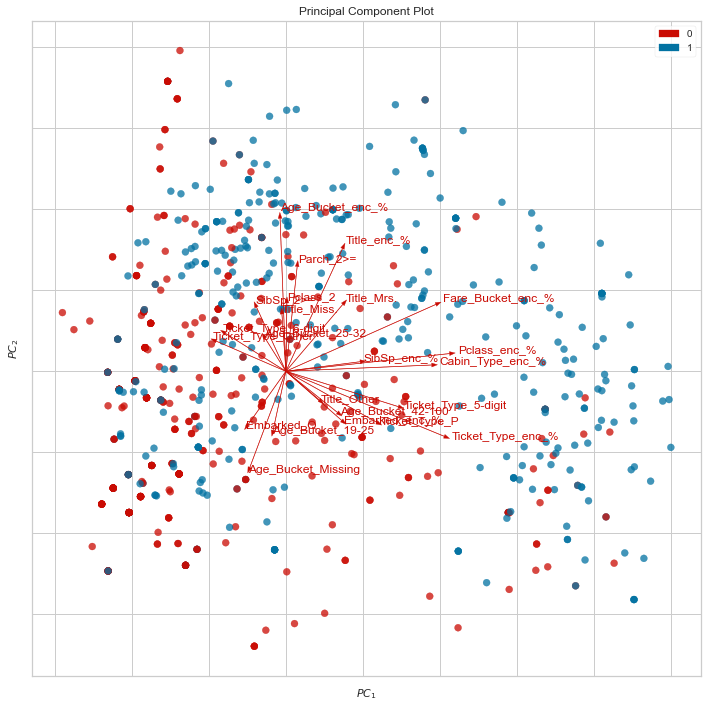

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [23]:
plt.figure(figsize=(10,10))
pca = pca.PCA(features=lr_selected_features, scale=True, proj_features=True, colors=('r','b'))
pca.fit_transform(X_train[lr_selected_features], y_train)
pca.show()

### KNeighbors

In [24]:
kn = KNeighborsClassifier(n_neighbors=20)
kn.fit(X_train, y_train)
perm = PermutationImportance(kn, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_kn = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_kn = perm_imp_kn.set_index('feature')
perm_imp_kn['Perm_Kn_Rank'] = perm_imp_kn['weight'].rank(ascending=False)
perm_imp_kn.head(15)

KNeighborsClassifier(n_neighbors=20)

weight       std  Perm_Kn_Rank
feature                                              
Title_enc_%          0.184328  0.014277           1.0
Age_Bucket_enc_%     0.018657  0.009440           2.0
Pclass_enc_%         0.008209  0.007235           3.0
SibSp_2>=            0.007463  0.000000           4.0
Title_Other          0.006716  0.001493           5.0
Age_Bucket_42-100    0.006716  0.002792           6.0
Title_Mrs.           0.005970  0.003805           7.0
Age_Bucket_25-32     0.004478  0.001493           8.0
Ticket_Type_Other    0.003731  0.003337           9.0
Age_Bucket_19-25     0.002985  0.003656          10.5
Title_Miss.          0.002985  0.005970          10.5
Ticket_Type_6-digit  0.002985  0.004950          12.0
SibSp_enc_%          0.002985  0.001493          13.0
Fare_Bucket_enc_%    0.001493  0.001828          14.0
Ticket_Type_5-digit  0.000000  0.000000          15.5

In [25]:
kn = KNeighborsClassifier(n_neighbors=20)
kn.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(kn, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
kn_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
kn_selection_perm

KNeighborsClassifier(n_neighbors=20)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=KNeighborsClassifier(n_neighbors=20),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

Embarked_enc_%       0
Title_enc_%          0
Ticket_Type_enc_%    0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Name: Selection_Perm, dtype: int64

In [26]:
feat_imp_kn = pd.concat([perm_imp_kn, kn_selection_perm], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_kn if 'Rank' in col] + ['Selection_Perm']
feat_imp_kn = feat_imp_kn[rank_columns]
feat_imp_kn['Overall_Rank'] = feat_imp_kn.sum(axis=1)
feat_imp_kn = feat_imp_kn.sort_values('Overall_Rank', ascending=True)
feat_imp_kn.head(30)

Perm_Kn_Rank  Selection_Perm  Overall_Rank
Title_enc_%                   1.0             0.0           1.0
Pclass_enc_%                  3.0             0.0           3.0
Age_Bucket_enc_%              2.0             5.0           7.0
SibSp_2>=                     4.0             5.0           9.0
Title_Other                   5.0             5.0          10.0
Age_Bucket_42-100             6.0             5.0          11.0
Title_Mrs.                    7.0             5.0          12.0
Age_Bucket_25-32              8.0             5.0          13.0
Ticket_Type_Other             9.0             5.0          14.0
Fare_Bucket_enc_%            14.0             0.0          14.0
Age_Bucket_19-25             10.5             5.0          15.5
Title_Miss.                  10.5             5.0          15.5
Ticket_Type_6-digit          12.0             5.0          17.0
SibSp_enc_%                  13.0             5.0          18.0
Ticket_Type_5-digit          15.5             5.0          20.5
Parch_enc_%                  15.5             5.0          20.5
Age_Bucket_32-42             17.0             5.0          22.0
Embarked_enc_%               23.0             0.0          23.0
Fare_Bucket_11-46            18.5             5.0          23.5
Pclass_2                     18.5             5.0          23.5
Ticket_Type_enc_%            24.5             0.0          24.5
Embarked_Q                   20.0             5.0          25.0
Parch_2>=                    21.0             5.0          26.0
Cabin_Type_enc_%             22.0             5.0          27.0
Ticket_Type_P                24.5             5.0          29.5
Age_Bucket_Missing           26.0             5.0          31.0

In [42]:
kn_selected_features = feat_imp_kn[(feat_imp_kn['Overall_Rank']<=10)].index.tolist()
print(kn_selected_features)

['Title_enc_%', 'Pclass_enc_%', 'Age_Bucket_enc_%', 'SibSp_2>=', 'Title_Other']


### SVC

In [28]:
svc = SVC(C=0.6, probability=True)
svc.fit(X_train, y_train)
perm = PermutationImportance(svc, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_svc = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_svc = perm_imp_svc.set_index('feature')
perm_imp_svc['Perm_Svc_Rank'] = perm_imp_svc['weight'].rank(ascending=False)
perm_imp_svc.head(15)

SVC(C=0.6, probability=True)

weight       std  Perm_Svc_Rank
feature                                               
Title_enc_%          0.261194  0.020437            1.0
SibSp_2>=            0.018657  0.003337            2.0
Age_Bucket_42-100    0.013433  0.002985            3.0
Pclass_enc_%         0.011940  0.002792            4.0
Embarked_enc_%       0.011194  0.007080            5.0
Age_Bucket_enc_%     0.008209  0.005970            6.0
Ticket_Type_6-digit  0.005970  0.001828            7.0
Fare_Bucket_11-46    0.003731  0.003337            8.0
Ticket_Type_5-digit  0.002985  0.001493            9.5
Parch_enc_%          0.002985  0.001493            9.5
Cabin_Type_enc_%     0.002239  0.004478           11.0
Ticket_Type_P        0.001493  0.001828           12.0
Ticket_Type_Other    0.000746  0.001493           13.5
Age_Bucket_19-25     0.000746  0.001493           13.5
Pclass_2             0.000746  0.003656           15.5

In [29]:
svc = SVC(C=0.6, probability=True)
svc.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(svc, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
svc_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
svc_selection_perm

SVC(C=0.6, probability=True)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=SVC(C=0.6, probability=True),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

Embarked_enc_%         0
Title_enc_%            0
Ticket_Type_enc_%      0
Cabin_Type_enc_%       0
Age_Bucket_enc_%       0
Fare_Bucket_enc_%      0
SibSp_enc_%            0
Parch_enc_%            0
Pclass_enc_%           0
Pclass_2               0
Embarked_Q             0
Title_Miss.            0
Title_Mrs.             0
Title_Other            0
Ticket_Type_5-digit    0
Ticket_Type_6-digit    0
Ticket_Type_Other      0
Ticket_Type_P          0
SibSp_2>=              0
Parch_2>=              0
Age_Bucket_19-25       0
Age_Bucket_25-32       0
Age_Bucket_32-42       0
Age_Bucket_42-100      0
Age_Bucket_Missing     0
Fare_Bucket_11-46      0
Name: Selection_Perm, dtype: int64

In [30]:
feat_imp_svc = pd.concat([perm_imp_svc, svc_selection_perm], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_svc if 'Rank' in col] + ['Selection_Perm']
feat_imp_svc = feat_imp_svc[rank_columns]
feat_imp_svc['Overall_Rank'] = feat_imp_svc.sum(axis=1)
feat_imp_svc = feat_imp_svc.sort_values('Overall_Rank', ascending=True)
feat_imp_svc.head(30)

Perm_Svc_Rank  Selection_Perm  Overall_Rank
Title_enc_%                    1.0               0           1.0
SibSp_2>=                      2.0               0           2.0
Age_Bucket_42-100              3.0               0           3.0
Pclass_enc_%                   4.0               0           4.0
Embarked_enc_%                 5.0               0           5.0
Age_Bucket_enc_%               6.0               0           6.0
Ticket_Type_6-digit            7.0               0           7.0
Fare_Bucket_11-46              8.0               0           8.0
Ticket_Type_5-digit            9.5               0           9.5
Parch_enc_%                    9.5               0           9.5
Cabin_Type_enc_%              11.0               0          11.0
Ticket_Type_P                 12.0               0          12.0
Age_Bucket_19-25              13.5               0          13.5
Ticket_Type_Other             13.5               0          13.5
Pclass_2                      15.5               0          15.5
Ticket_Type_enc_%             15.5               0          15.5
Age_Bucket_Missing            17.5               0          17.5
Title_Mrs.                    17.5               0          17.5
Title_Other                   19.0               0          19.0
Embarked_Q                    21.0               0          21.0
Age_Bucket_25-32              21.0               0          21.0
Parch_2>=                     21.0               0          21.0
Age_Bucket_32-42              23.0               0          23.0
Title_Miss.                   24.5               0          24.5
Fare_Bucket_enc_%             24.5               0          24.5
SibSp_enc_%                   26.0               0          26.0

In [44]:
svc_selected_features = feat_imp_svc[(feat_imp_svc['Overall_Rank']<=8)].index.tolist()
print(svc_selected_features)

['Title_enc_%', 'SibSp_2>=', 'Age_Bucket_42-100', 'Pclass_enc_%', 'Embarked_enc_%', 'Age_Bucket_enc_%', 'Ticket_Type_6-digit', 'Fare_Bucket_11-46']


### RandomForest

In [32]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)
imp_rf = pd.DataFrame(rf.feature_importances_, 
                      index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_rf['Rf_Rank'] = imp_rf['Importance'].rank(ascending=False)
imp_rf.head(15)

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

Importance  Rf_Rank
Title_enc_%            0.261220      1.0
Pclass_enc_%           0.076636      2.0
Age_Bucket_enc_%       0.065418      3.0
Cabin_Type_enc_%       0.059312      4.0
SibSp_enc_%            0.059188      5.0
Ticket_Type_enc_%      0.056433      6.0
Fare_Bucket_enc_%      0.052796      7.0
Title_Miss.            0.046079      8.0
Title_Mrs.             0.041030      9.0
Parch_enc_%            0.038273     10.0
Embarked_enc_%         0.036064     11.0
Age_Bucket_42-100      0.022478     12.0
Ticket_Type_6-digit    0.020872     13.0
Pclass_2               0.019904     14.0
SibSp_2>=              0.019100     15.0

In [33]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)
perm = PermutationImportance(rf, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_rf = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_rf = perm_imp_rf.set_index('feature')
perm_imp_rf['Perm_Rf_Rank'] = perm_imp_rf['weight'].rank(ascending=False)
perm_imp_rf.head(15)

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

weight       std  Perm_Rf_Rank
feature                                                  
Title_enc_%          2.141791e-01  0.026342           1.0
Embarked_enc_%       4.477612e-03  0.002792           2.0
Parch_2>=            7.462687e-04  0.001493           3.0
Title_Other          0.000000e+00  0.000000           4.0
Age_Bucket_19-25    -2.220446e-17  0.002360           5.0
Ticket_Type_P       -7.462687e-04  0.001493           6.5
Embarked_Q          -7.462687e-04  0.001493           6.5
Age_Bucket_42-100   -7.462687e-04  0.004351           8.5
Fare_Bucket_enc_%   -7.462687e-04  0.002792           8.5
Title_Miss.         -1.492537e-03  0.003805          10.5
Ticket_Type_5-digit -1.492537e-03  0.001828          10.5
SibSp_2>=           -2.238806e-03  0.002985          12.0
Title_Mrs.          -2.985075e-03  0.001493          13.0
Pclass_enc_%        -2.985075e-03  0.007610          14.0
Age_Bucket_Missing  -3.731343e-03  0.007463          16.0

In [34]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)

selection = RFECV(rf, min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
rf_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
rf_selection

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=RandomForestClassifier(max_depth=10, n_estimators=200,
                                       oob_score=True, random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

Embarked_enc_%         0
Title_enc_%            0
Ticket_Type_enc_%      0
Cabin_Type_enc_%       0
Age_Bucket_enc_%       0
Fare_Bucket_enc_%      0
SibSp_enc_%            0
Parch_enc_%            0
Pclass_enc_%           0
Pclass_2               0
Title_Miss.            0
Title_Mrs.             0
Ticket_Type_5-digit    0
Ticket_Type_6-digit    0
SibSp_2>=              0
Age_Bucket_25-32       0
Age_Bucket_Missing     0
Fare_Bucket_11-46      0
Name: Selection, dtype: int64

In [35]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(rf, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
rf_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
rf_selection_perm

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=RandomForestClassifier(max_depth=10,
                                                                       n_estimators=200,
                                                                       oob_score=True,
                                                                       random_state=1),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

Embarked_enc_%       0
Title_enc_%          0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Title_Miss.          0
SibSp_2>=            0
Name: Selection_Perm, dtype: int64

In [36]:
feat_imp_rf = pd.concat([imp_rf, perm_imp_rf, rf_selection, rf_selection_perm], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_rf if 'Rank' in col] + ['Selection', 'Selection_Perm']
feat_imp_rf = feat_imp_rf[rank_columns]
feat_imp_rf['Overall_Rank'] = feat_imp_rf.sum(axis=1)
feat_imp_rf = feat_imp_rf.sort_values('Overall_Rank', ascending=True)
feat_imp_rf.head(30)

Rf_Rank  Perm_Rf_Rank  Selection  Selection_Perm  \
Title_enc_%              1.0           1.0        0.0             0.0   
Embarked_enc_%          11.0           2.0        0.0             0.0   
Fare_Bucket_enc_%        7.0           8.5        0.0             0.0   
Pclass_enc_%             2.0          14.0        0.0             0.0   
Title_Miss.              8.0          10.5        0.0             0.0   
Age_Bucket_enc_%         3.0          16.0        0.0             5.0   
SibSp_2>=               15.0          12.0        0.0             0.0   
Title_Mrs.               9.0          13.0        0.0             5.0   
Age_Bucket_42-100       12.0           8.5        5.0             5.0   
Ticket_Type_enc_%        6.0          20.0        0.0             5.0   
SibSp_enc_%              5.0          22.0        0.0             5.0   
Cabin_Type_enc_%         4.0          23.5        0.0             5.0   
Parch_2>=               21.0           3.0        5.0             5.0   
Ticket_Type_5-digit     22.0          10.5        0.0             5.0   
Age_Bucket_19-25        23.0           5.0        5.0             5.0   
Parch_enc_%             10.0          23.5        0.0             5.0   
Pclass_2                14.0          20.0        0.0             5.0   
Age_Bucket_25-32        18.0          16.0        0.0             5.0   
Title_Other             26.0           4.0        5.0             5.0   
Fare_Bucket_11-46       17.0          18.0        0.0             5.0   
Embarked_Q              24.0           6.5        5.0             5.0   
Age_Bucket_Missing      20.0          16.0        0.0             5.0   
Ticket_Type_P           25.0           6.5        5.0             5.0   
Ticket_Type_6-digit     13.0          26.0        0.0             5.0   
Age_Bucket_32-42        16.0          20.0        5.0             5.0   
Ticket_Type_Other       19.0          25.0        5.0             5.0   

                     Overall_Rank  
Title_enc_%                   2.0  
Embarked_enc_%               13.0  
Fare_Bucket_enc_%            15.5  
Pclass_enc_%                 16.0  
Title_Miss.                  18.5  
Age_Bucket_enc_%             24.0  
SibSp_2>=                    27.0  
Title_Mrs.                   27.0  
Age_Bucket_42-100            30.5  
Ticket_Type_enc_%            31.0  
SibSp_enc_%                  32.0  
Cabin_Type_enc_%             32.5  
Parch_2>=                    34.0  
Ticket_Type_5-digit          37.5  
Age_Bucket_19-25             38.0  
Parch_enc_%                  38.5  
Pclass_2                     39.0  
Age_Bucket_25-32             39.0  
Title_Other                  40.0  
Fare_Bucket_11-46            40.0  
Embarked_Q                   40.5  
Age_Bucket_Missing           41.0  
Ticket_Type_P                41.5  
Ticket_Type_6-digit          44.0  
Age_Bucket_32-42             46.0  
Ticket_Type_Other            54.0

In [45]:
rf_selected_features = feat_imp_rf[(feat_imp_rf['Overall_Rank']<=25)].index.tolist()
print(rf_selected_features)

['Title_enc_%', 'Embarked_enc_%', 'Fare_Bucket_enc_%', 'Pclass_enc_%', 'Title_Miss.', 'Age_Bucket_enc_%']


### XGB

In [38]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
imp_xgb = pd.DataFrame(xgb.feature_importances_, 
                      index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
imp_xgb['Xgb_Rank'] = imp_xgb['Importance'].rank(ascending=False)
imp_xgb.head(15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Importance  Xgb_Rank
Title_Other            0.292884       1.0
Title_enc_%            0.241566       2.0
Pclass_enc_%           0.071691       3.0
Cabin_Type_enc_%       0.060797       4.0
Age_Bucket_42-100      0.037285       5.0
SibSp_enc_%            0.032679       6.0
Age_Bucket_25-32       0.031758       7.0
Age_Bucket_32-42       0.025377       8.0
Pclass_2               0.022875       9.0
Ticket_Type_enc_%      0.021950      10.0
Parch_2>=              0.019840      11.0
Embarked_enc_%         0.017505      12.0
Fare_Bucket_enc_%      0.017277      13.0
Ticket_Type_6-digit    0.016865      14.0
Age_Bucket_enc_%       0.016343      15.0

In [39]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
perm = PermutationImportance(xgb, random_state=1, cv=cv).fit(X_test.values, y_test.values)
perm_imp_xgb = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_xgb = perm_imp_xgb.set_index('feature')
perm_imp_xgb['Perm_Xgb_Rank'] = perm_imp_xgb['weight'].rank(ascending=False)
perm_imp_xgb.head(15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

weight       std  Perm_Xgb_Rank
feature                                             
Title_enc_%        0.180881  0.066186            1.0
Embarked_enc_%     0.039748  0.047223            2.0
SibSp_enc_%        0.023913  0.016288            3.0
Ticket_Type_enc_%  0.007547  0.035329            4.0
Cabin_Type_enc_%   0.005940  0.015512            5.0
Fare_Bucket_enc_%  0.002977  0.026130            6.0
Age_Bucket_enc_%   0.002236  0.027035            7.0
Embarked_Q         0.001495  0.007291            8.0
Title_Miss.        0.000014  0.014027            9.0
Title_Other        0.000000  0.000000           12.5
Title_Mrs.         0.000000  0.000000           12.5
Ticket_Type_Other  0.000000  0.000000           12.5
Ticket_Type_P      0.000000  0.000000           12.5
SibSp_2>=          0.000000  0.000000           12.5
Age_Bucket_19-25   0.000000  0.000000           12.5

In [40]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
selection = RFECV(xgb, min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
xgb_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
xgb_selection

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=200,
                              n_jobs=0, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None),
      min_features_to_select=5, scoring='roc_auc', step=4)

Embarked_enc_%        0
Title_enc_%           0
SibSp_enc_%           0
Pclass_enc_%          0
Age_Bucket_Missing    0
Name: Selection, dtype: int64

In [47]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(xgb, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
xgb_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
xgb_selection_perm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=XGBClassifier(base_score=0.5,
                                                              booster='gbtree',
                                                              colsample_bylevel=1,
                                                              colsample_bynode=1,
                                                              colsample_bytree=1,
                                                              gamma=0,
                                                              gpu_id=-1,
                                                              importance_type='gain',
                                                              interaction_constraints='',
                                                              learning_rate=0.1,
                                            

Embarked_enc_%         0
Title_enc_%            0
Pclass_enc_%           0
Pclass_2               0
Ticket_Type_6-digit    0
Age_Bucket_42-100      0
Name: Selection_Perm, dtype: int64

In [48]:
feat_imp_xgb = pd.concat([imp_xgb, perm_imp_xgb, xgb_selection, xgb_selection_perm], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_xgb if 'Rank' in col] + ['Selection','Selection_Perm']
feat_imp_xgb = feat_imp_xgb[rank_columns]
feat_imp_xgb['Overall_Rank'] = feat_imp_xgb.sum(axis=1)
feat_imp_xgb = feat_imp_xgb.sort_values('Overall_Rank', ascending=True)
feat_imp_xgb.head(30)

Xgb_Rank  Perm_Xgb_Rank  Selection  Selection_Perm  \
Title_enc_%               2.0            1.0        0.0             0.0   
Embarked_enc_%           12.0            2.0        0.0             0.0   
SibSp_enc_%               6.0            3.0        0.0             5.0   
Pclass_enc_%              3.0           16.0        0.0             0.0   
Cabin_Type_enc_%          4.0            5.0        5.0             5.0   
Title_Other               1.0           12.5        5.0             5.0   
Ticket_Type_enc_%        10.0            4.0        5.0             5.0   
Fare_Bucket_enc_%        13.0            6.0        5.0             5.0   
Age_Bucket_enc_%         15.0            7.0        5.0             5.0   
Pclass_2                  9.0           20.0        5.0             0.0   
Age_Bucket_42-100         5.0           26.0        5.0             0.0   
Age_Bucket_25-32          7.0           21.0        5.0             5.0   
Title_Miss.              19.0            9.0        5.0             5.0   
Embarked_Q               21.0            8.0        5.0             5.0   
Parch_2>=                11.0           19.0        5.0             5.0   
Age_Bucket_32-42          8.0           22.0        5.0             5.0   
Ticket_Type_6-digit      14.0           23.0        5.0             0.0   
Age_Bucket_Missing       20.0           17.5        0.0             5.0   
Ticket_Type_5-digit      18.0           17.5        5.0             5.0   
Ticket_Type_P            24.0           12.5        5.0             5.0   
Ticket_Type_Other        24.0           12.5        5.0             5.0   
Age_Bucket_19-25         24.0           12.5        5.0             5.0   
SibSp_2>=                24.0           12.5        5.0             5.0   
Title_Mrs.               24.0           12.5        5.0             5.0   
Fare_Bucket_11-46        16.0           25.0        5.0             5.0   
Parch_enc_%              17.0           24.0        5.0             5.0   

                     Overall_Rank  
Title_enc_%                   3.0  
Embarked_enc_%               14.0  
SibSp_enc_%                  14.0  
Pclass_enc_%                 19.0  
Cabin_Type_enc_%             19.0  
Title_Other                  23.5  
Ticket_Type_enc_%            24.0  
Fare_Bucket_enc_%            29.0  
Age_Bucket_enc_%             32.0  
Pclass_2                     34.0  
Age_Bucket_42-100            36.0  
Age_Bucket_25-32             38.0  
Title_Miss.                  38.0  
Embarked_Q                   39.0  
Parch_2>=                    40.0  
Age_Bucket_32-42             40.0  
Ticket_Type_6-digit          42.0  
Age_Bucket_Missing           42.5  
Ticket_Type_5-digit          45.5  
Ticket_Type_P                46.5  
Ticket_Type_Other            46.5  
Age_Bucket_19-25             46.5  
SibSp_2>=                    46.5  
Title_Mrs.                   46.5  
Fare_Bucket_11-46            51.0  
Parch_enc_%                  51.0

In [49]:
xgb_selected_features = feat_imp_xgb[feat_imp_xgb['Perm_Rank']<=25].index.tolist()
print(xgb_selected_features)

['Title_enc_%', 'Embarked_enc_%', 'SibSp_enc_%', 'Cabin_Type_enc_%', 'Ticket_Type_enc_%', 'Fare_Bucket_enc_%', 'Age_Bucket_enc_%', 'Title_Miss.', 'Embarked_Q']


In [51]:
with open(os.path.join(project_path, r'data\svc_selected_features.txt'), "wb") as f:
      pickle.dump(svc_selected_features, f)
with open(os.path.join(project_path, r'data\lr_selected_features.txt'), "wb") as f:
      pickle.dump(lr_selected_features, f)
with open(os.path.join(project_path, r'data\kn_selected_features.txt'), "wb") as f:
      pickle.dump(kn_selected_features, f)
with open(os.path.join(project_path, r'data\rf_selected_features.txt'), "wb") as f:
      pickle.dump(rf_selected_features, f)
with open(os.path.join(project_path, r'data\xgb_selected_features.txt'), "wb") as f:
      pickle.dump(xgb_selected_features, f)